# 基于孕妇体表电极的胎儿心拍提取

In [407]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
%matplotlib inline

## 1. 了解心电mat文件数据结构

In [431]:
#读取mat文件，打印其中的数据存储结构
mat_contents = sio.loadmat('a01.mat')
print(len(mat_contents))
print(mat_contents)

6
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Dec 14 09:05:22 2020', '__version__': '1.0', '__globals__': [], 'Fs': array([[1000]], dtype=uint16), 'signal': array([[-3.3, -6.7,  3. , -3.5],
       [-3.8, -6.7,  3. , -3.5],
       [-4.4, -6.8,  3.2, -3.5],
       ...,
       [ 4.2,  6.7,  7.6,  9.5],
       [ 4.2,  7. ,  7. ,  8.8],
       [ 4.1,  7.3,  6.4,  8.1]]), 'tm': array([[0.0000e+00],
       [1.0000e-03],
       [2.0000e-03],
       ...,
       [5.9997e+01],
       [5.9998e+01],
       [5.9999e+01]])}


可以看出，本mat文件包含{"header","version","globals","Fs","signal","tm"}六类信息<br/>其中比较重要的信息有：<br/>1.采样率Fs=1000<br/>2.心电数据signal(4通道)<br/>3.时间轴tm

In [432]:
sigs=mat_contents["signal"]#包含有4通道数据，shape=[60000,4]
t=mat_contents["tm"]#t=0~60s,shape=[60000,1]

四个通道数据的显示

D:\miniconda3\install\envs\python36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\miniconda3\install\envs\python36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


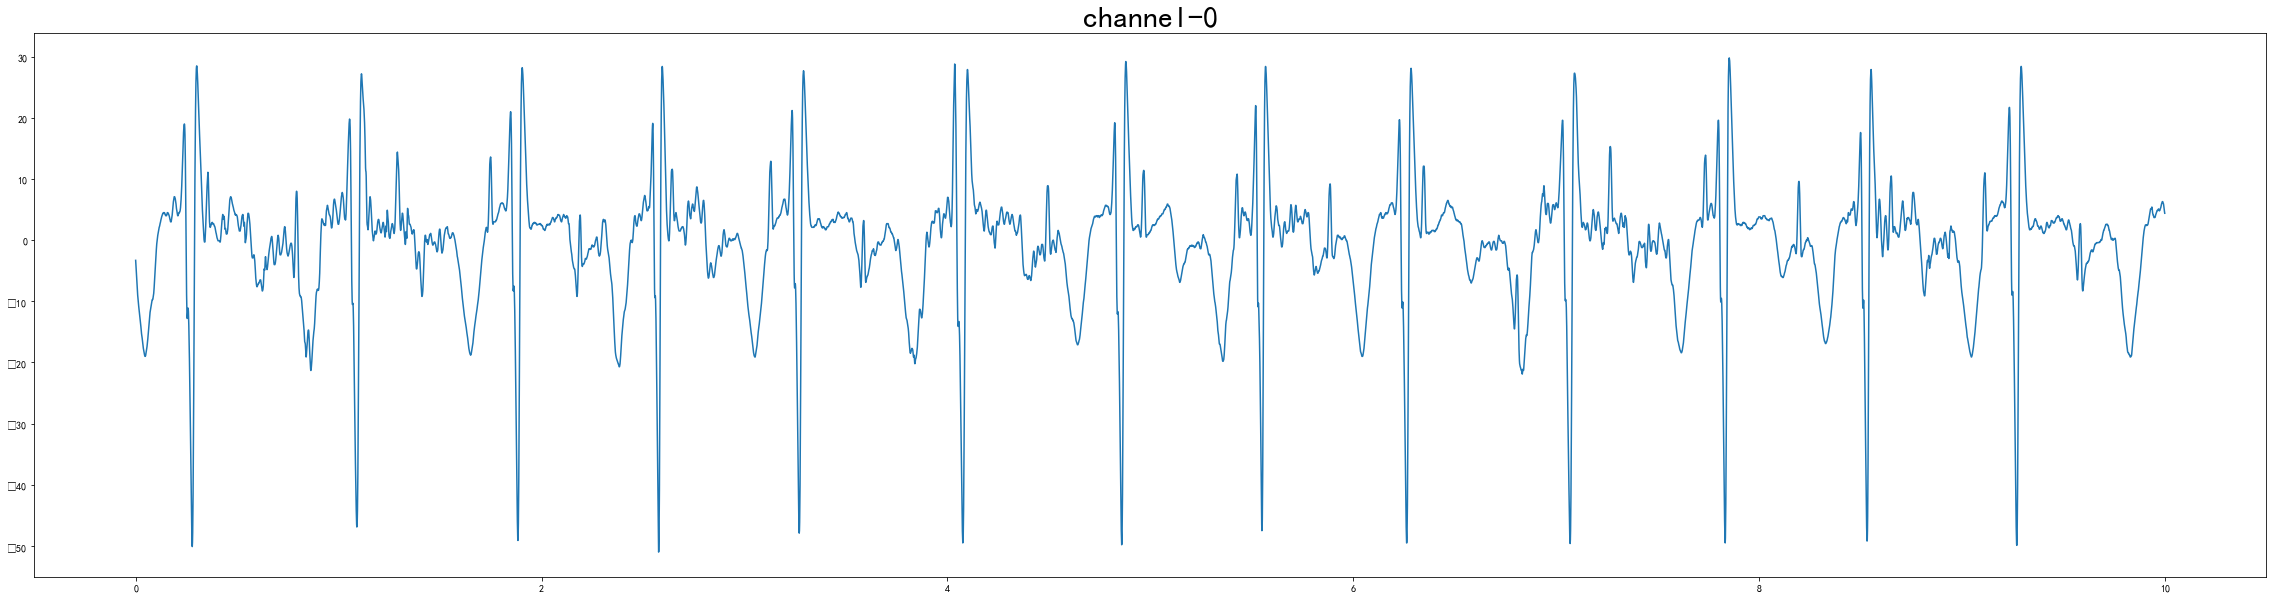

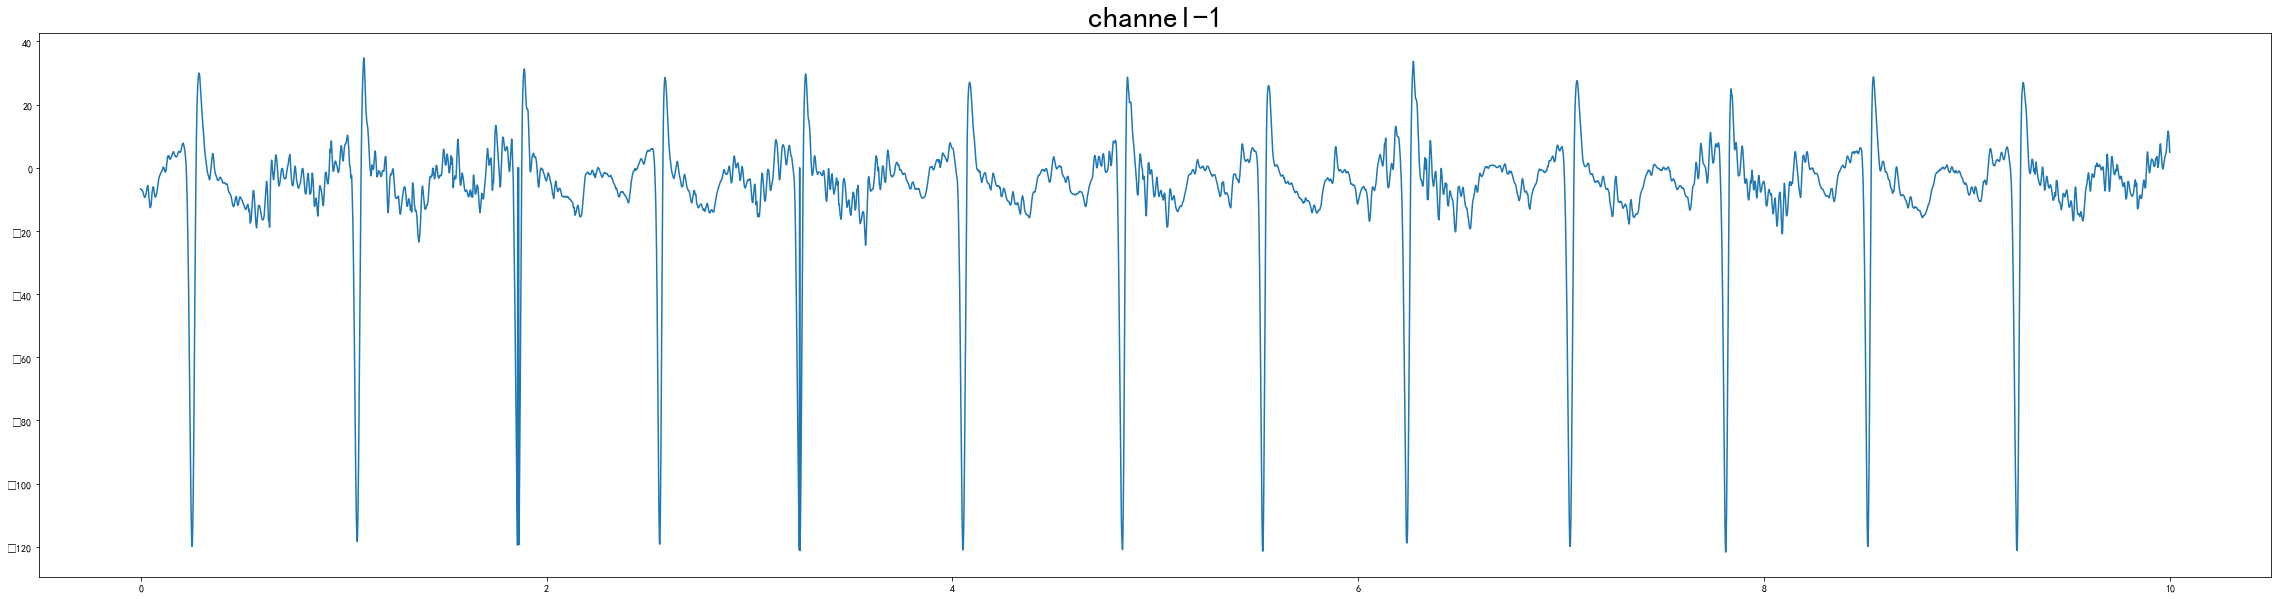

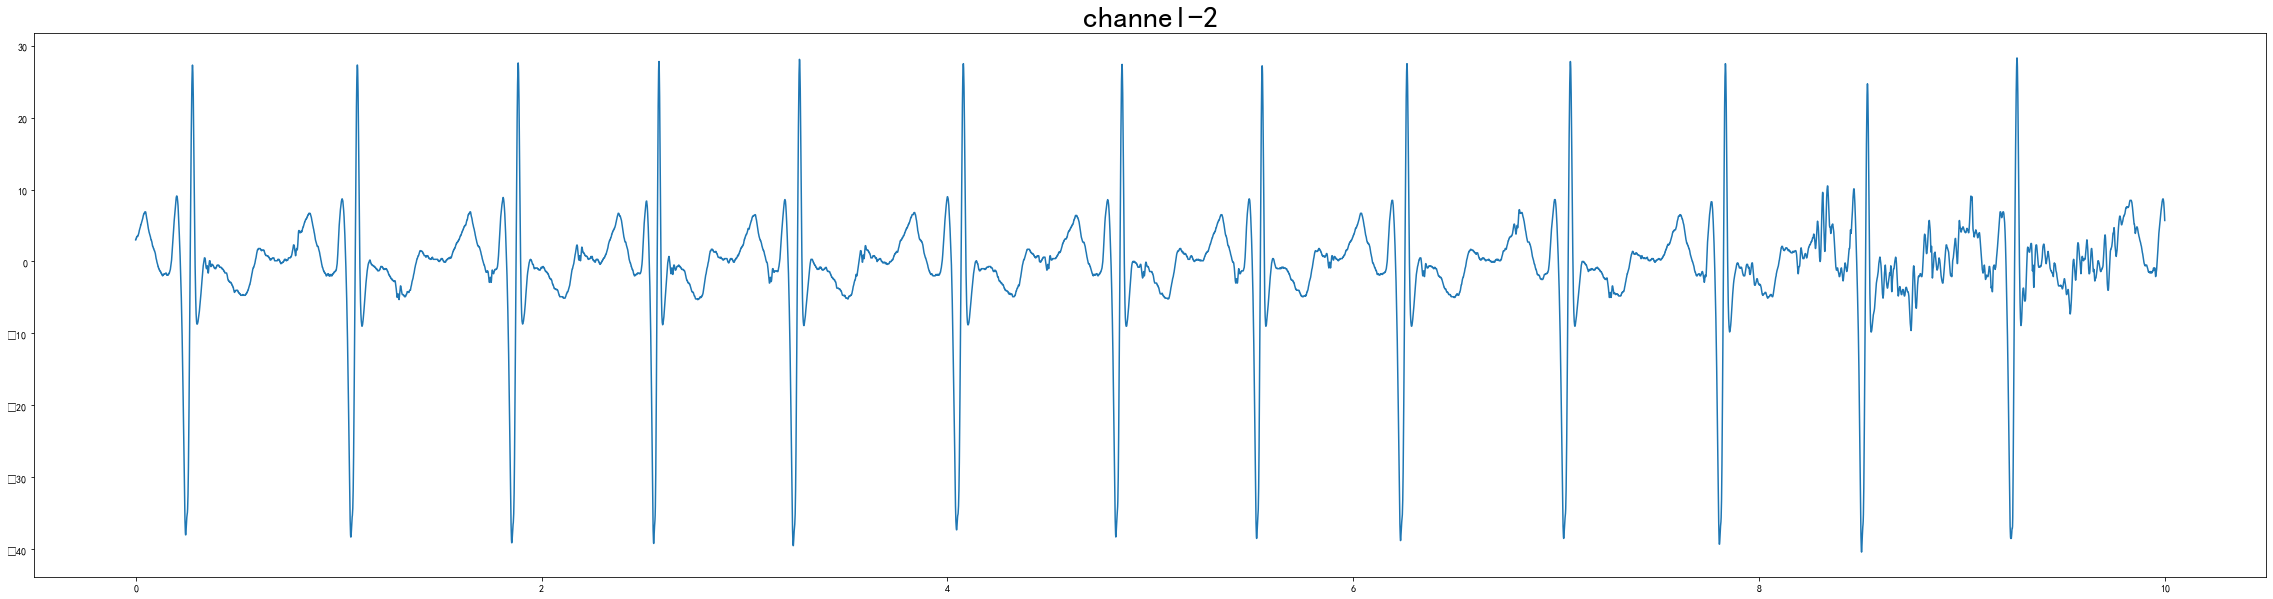

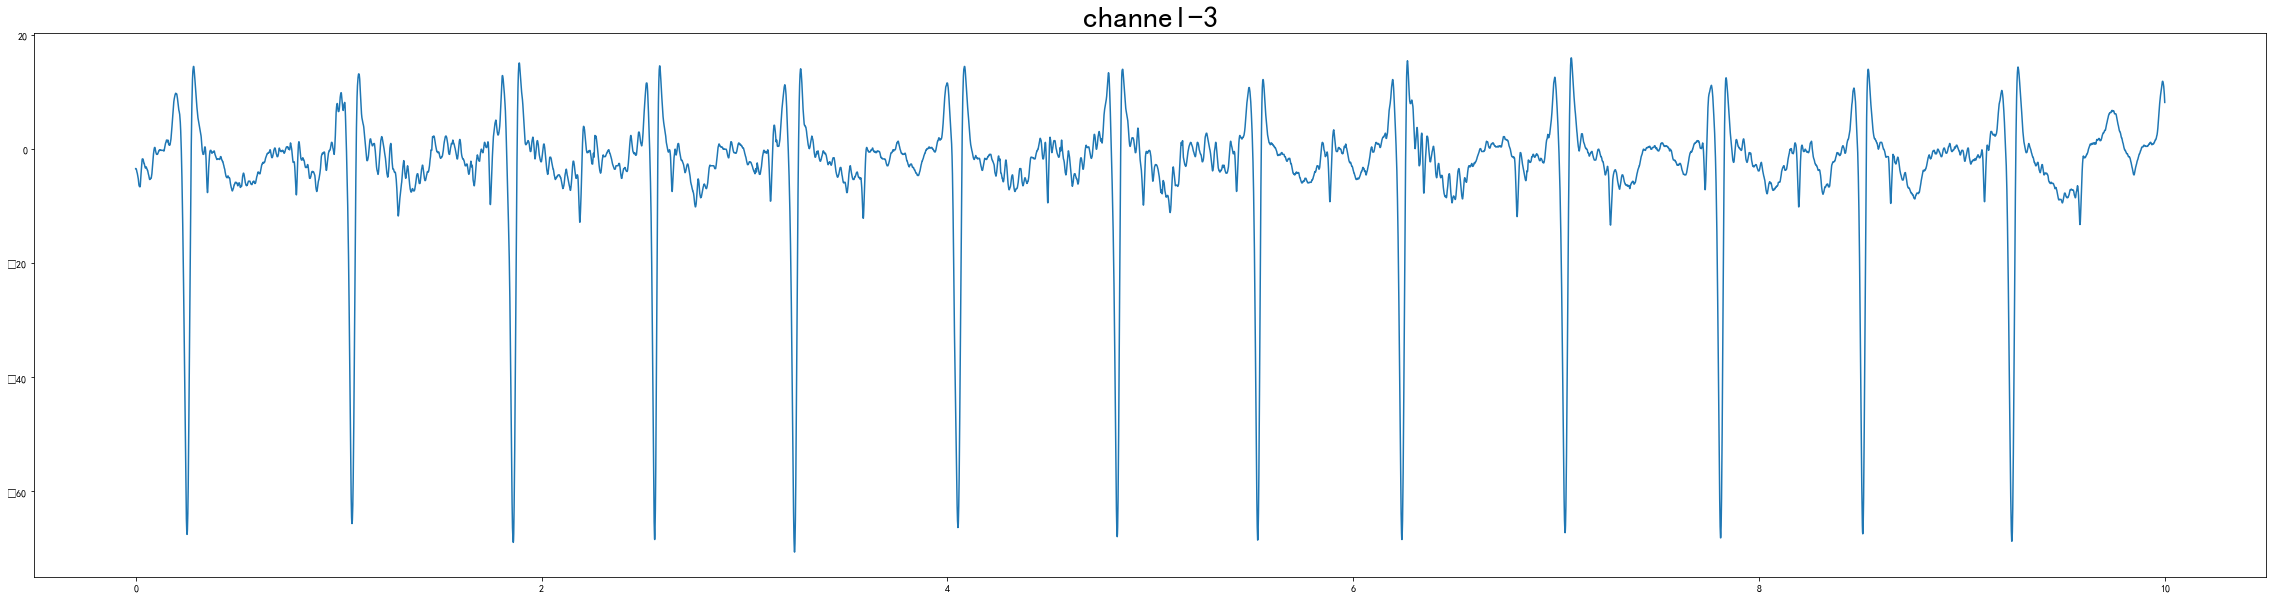

In [433]:
for i in range(4):
    plt.figure(i)
    sig=sigs[:,i]
    for j in range(len(sig)):
        if sig[j]<-500:
            sig[j]=0
    plt.plot(t[:10000],sig[:10000])
    plt.title("channel-"+str(i),fontsize=30)
plt.rcParams['figure.figsize'] = (40, 5) 
plt.show()

四个通道的波形可以看出，胎儿心电信号较明显的是第四个通道，也即channel3

## 2.预处理——简单滤波

D:\miniconda3\install\envs\python36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\miniconda3\install\envs\python36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


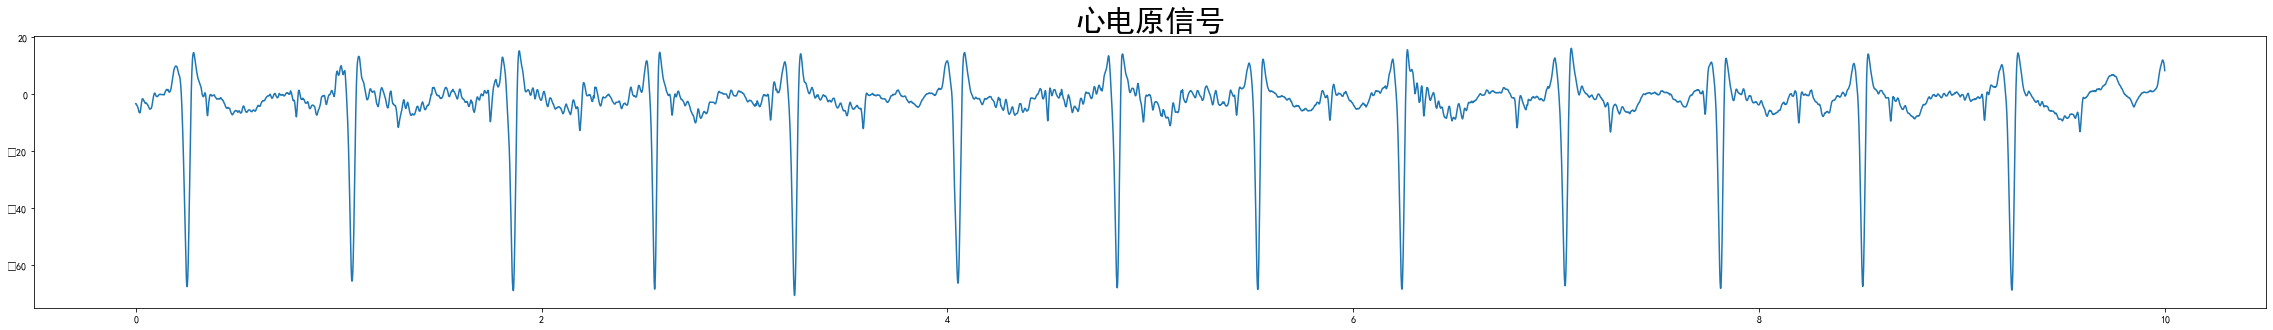

In [434]:
import scipy.signal as signal

sig=sigs[:,3]
plt.figure
plt.plot(t[:10000],sig[:10000])
plt.rcParams['figure.figsize'] = (40, 5) 
plt.title("心电原信号",fontsize=30)
plt.show()


中值滤波——去除基线漂移

D:\miniconda3\install\envs\python36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\miniconda3\install\envs\python36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


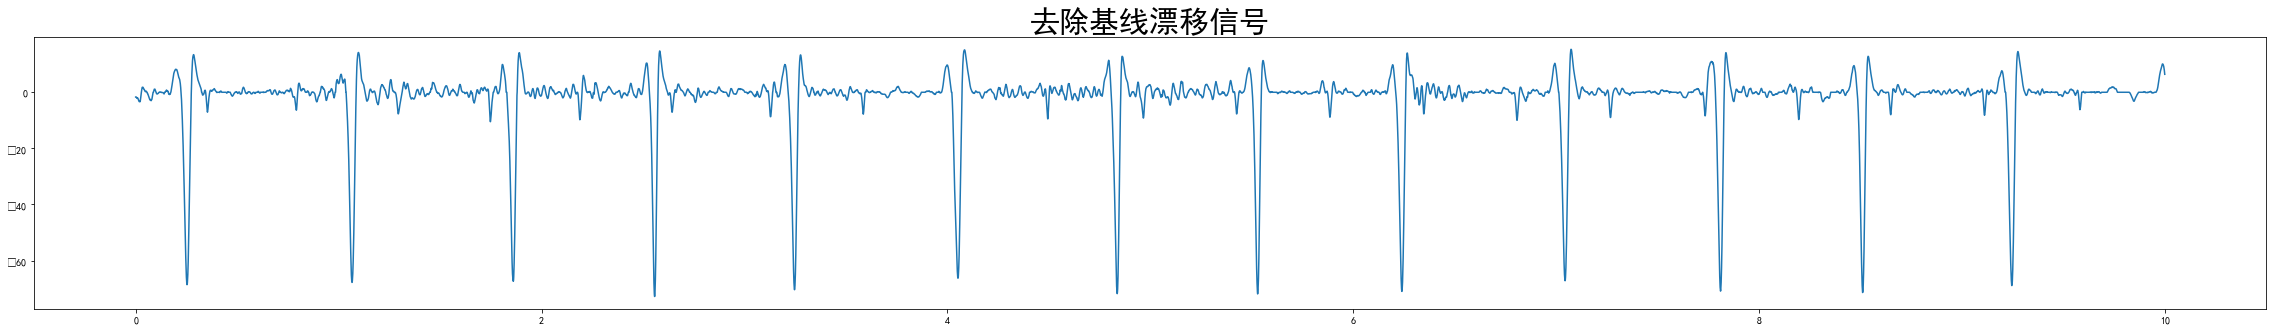

In [435]:
baseline=signal.medfilt(sig,101)
sig_baseline=sig-baseline

plt.figure
plt.plot(t[:10000],sig_baseline[:10000])
#plt.plot(t[:10000],sig_baseline2[:10000])
plt.rcParams['figure.figsize'] = (40, 10) 
plt.title("去除基线漂移信号",fontsize=30)
plt.show()

## 3.母亲R峰检测

检测R波

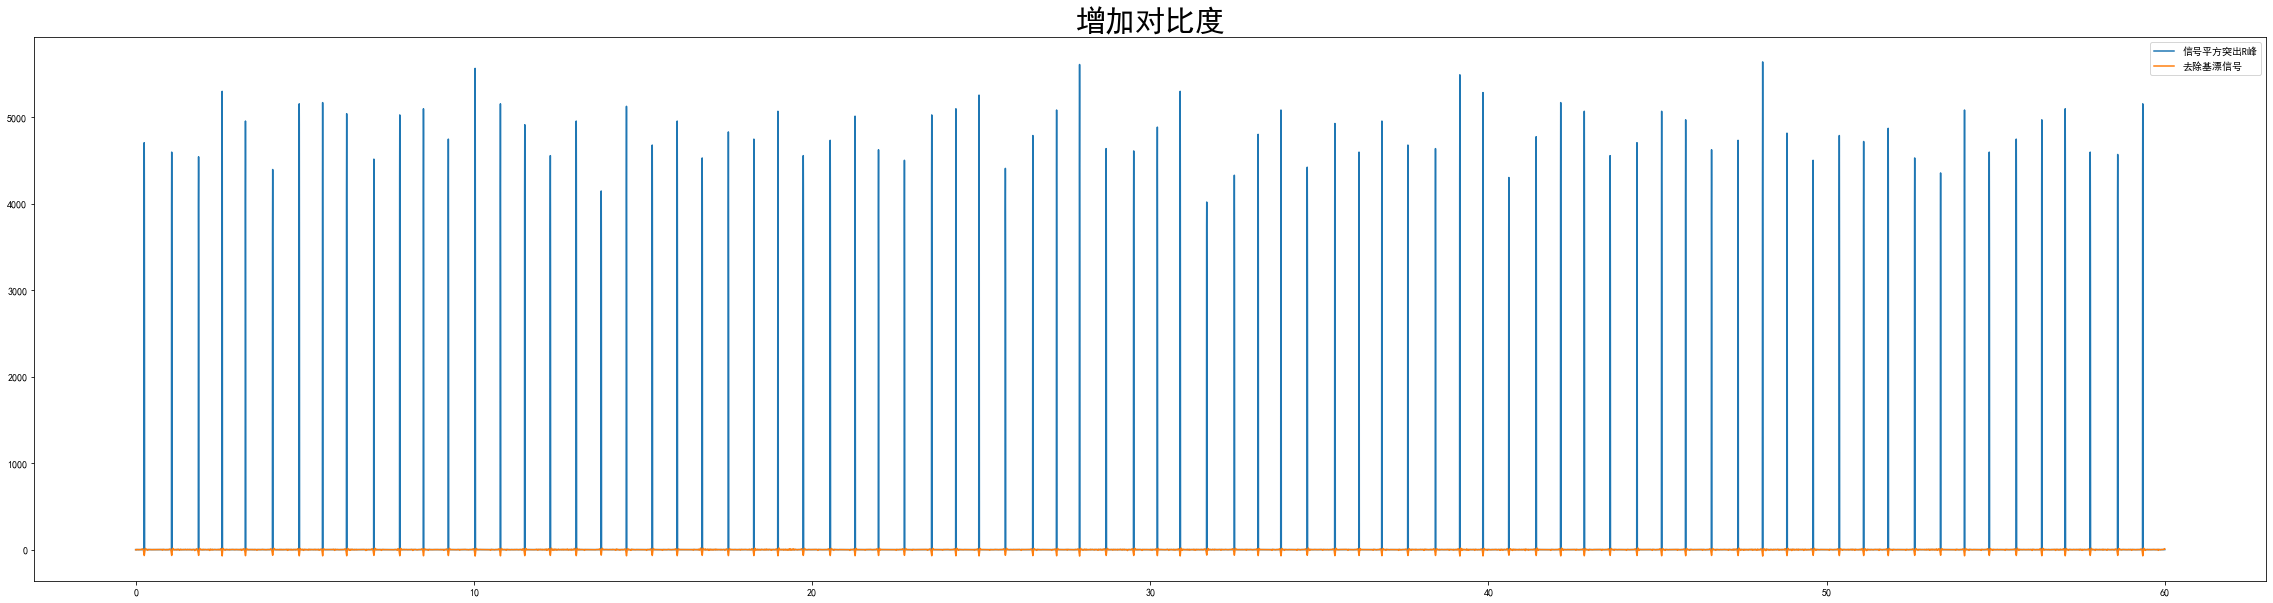

D:\miniconda3\install\envs\python36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\miniconda3\install\envs\python36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


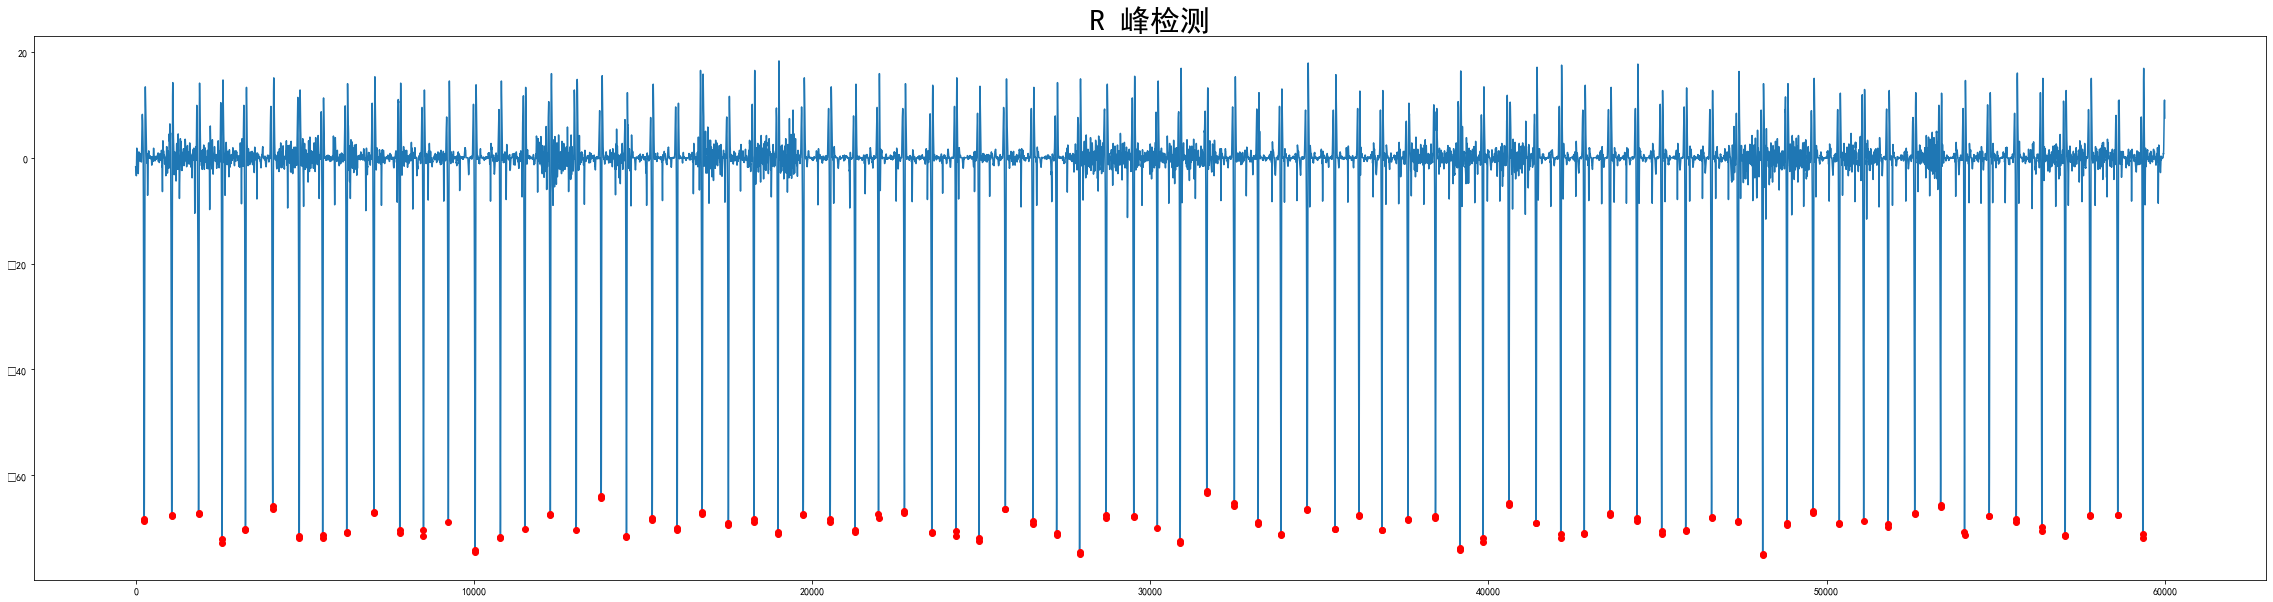

D:\miniconda3\install\envs\python36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\miniconda3\install\envs\python36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


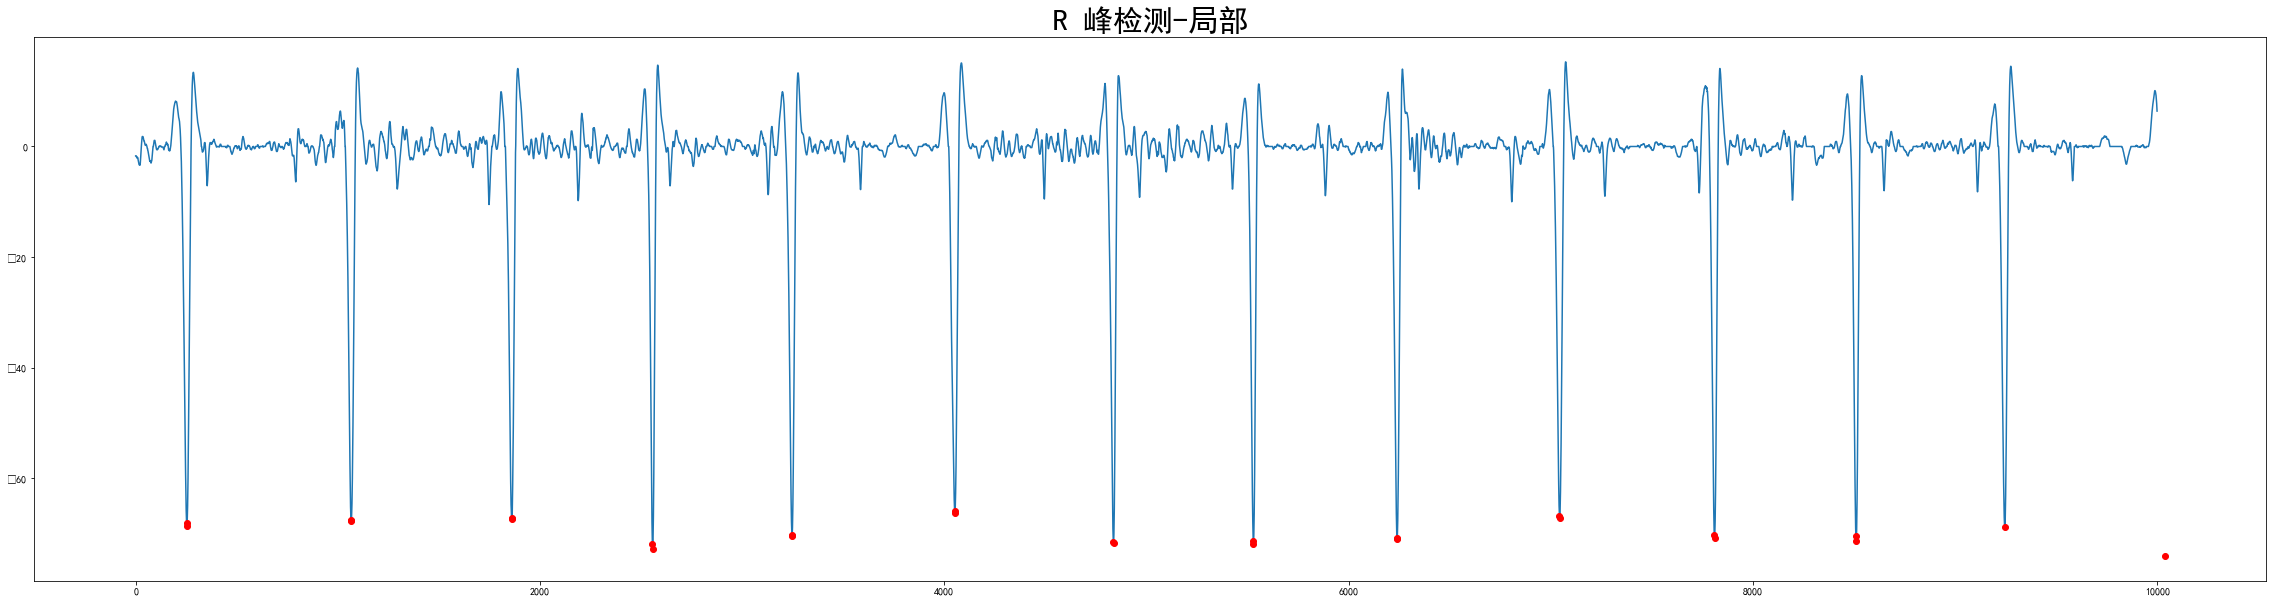

In [436]:
sig_pow2=sig_baseline**2  #首先对信号平方，拉大差距，便于找出R峰所在位置
mark=max(sig_pow2)*0.5  #对小于R**2的值置零
L=sig_pow2.size  #L=60000，与原信号等长

for i in range(L):
    if sig_pow2[i]<=mark:
        sig_pow2[i]=0
        
        
sig_detectR=sig_pow2   

#对信号做一阶差分，根据极点知识找出R峰的位置
sig_diff=np.convolve(sig_detectR,np.array([1,-1]),"full")
indexR=[]  #R峰的横坐标值*1000
y_value=[]
for i in range(L-1):
    if sig_diff[i]*sig_diff[i+2]<0 :
        indexR.append(i)
        y_value.append(sig_baseline[i])

plt.figure(0)
plt.plot(t,sig_detectR,label="信号平方突出R峰")
plt.plot(t,sig_baseline,label="去除基漂信号")
#plt.plot(indexR,y_value,"o",color="red")
plt.rcParams['figure.figsize'] = (40, 10) 
plt.title("增加对比度",fontsize=30)
plt.legend()
plt.show()
        
plt.figure(1)
#plt.plot(t*1000,sig_detectR)
plt.plot(t*1000,sig_baseline)
plt.plot(indexR,y_value,"o",color="red")
plt.rcParams['figure.figsize'] = (40, 10) 
plt.title("R 峰检测",fontsize=30)
plt.show()

plt.figure(2)

plt.plot(t[:10000]*1000,sig_baseline[:10000])
plt.plot(indexR[:26],y_value[:26],"o",color="red")
plt.rcParams['figure.figsize'] = (40, 10) 
plt.title("R 峰检测-局部",fontsize=30)
plt.show()

先验知识：正常成年人的QRS波时间范围为0.06s-0.12s<br/>对时间分辨率为1/1000的心电信号而言,数据宽度为60-120个点<br/>对QRS波置0

D:\miniconda3\install\envs\python36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\miniconda3\install\envs\python36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


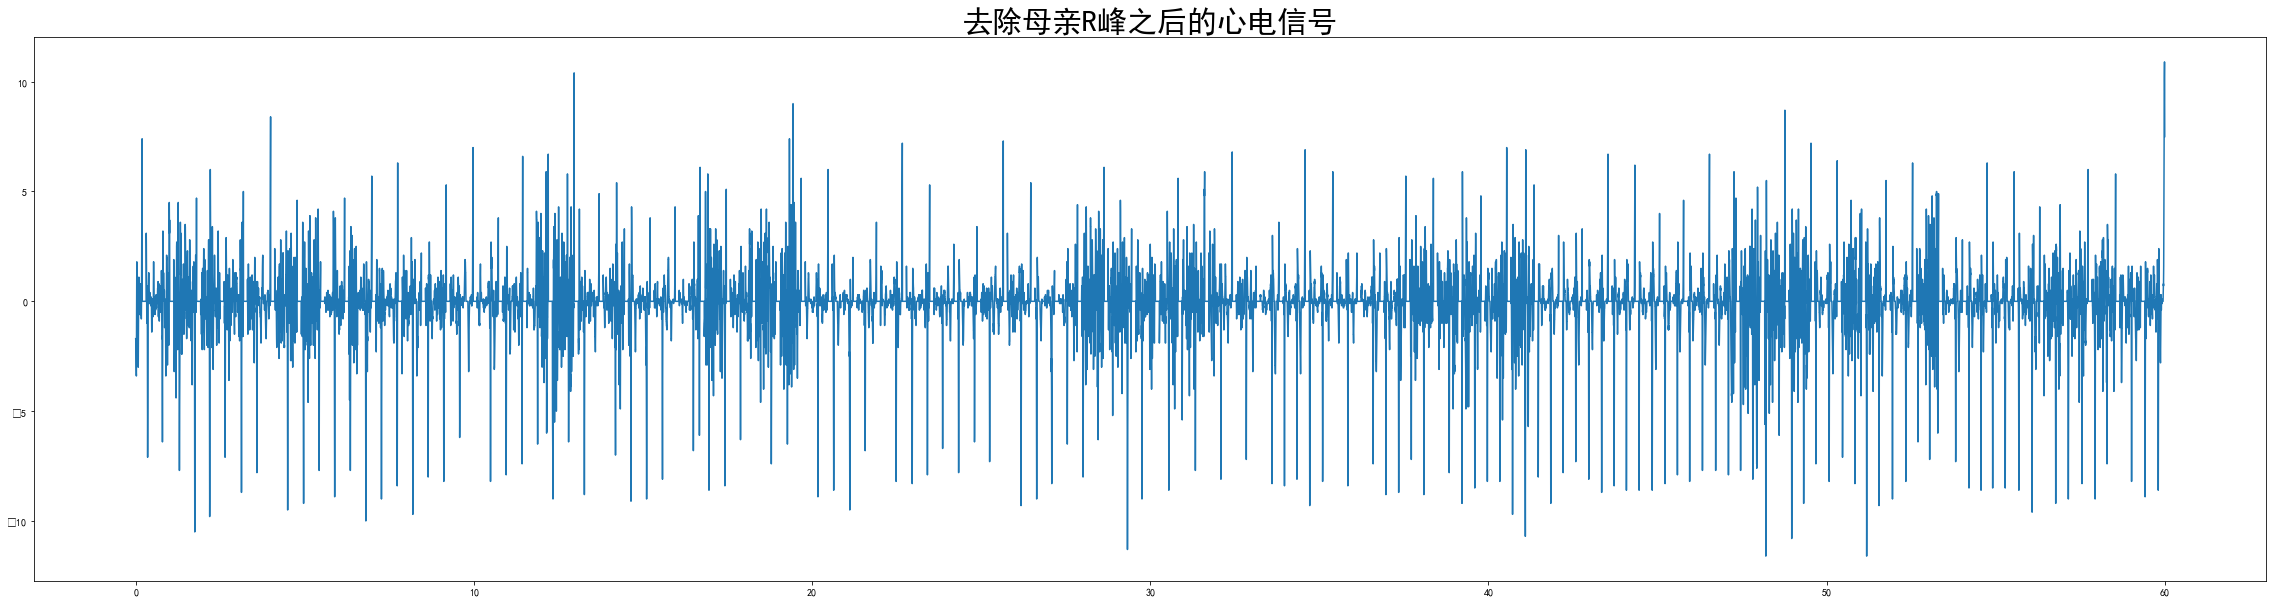

D:\miniconda3\install\envs\python36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\miniconda3\install\envs\python36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


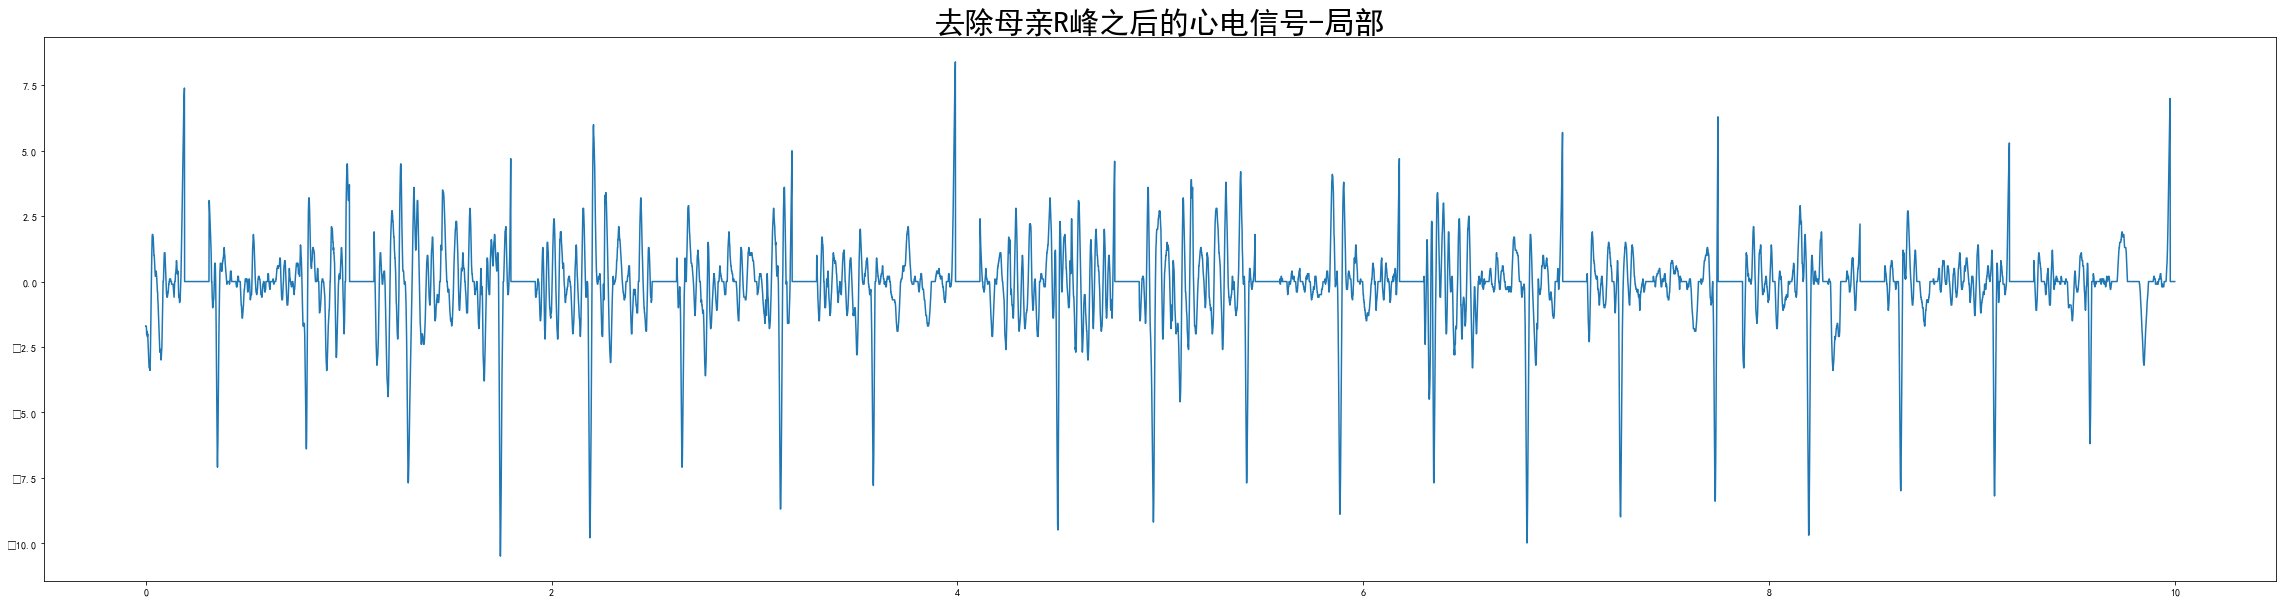

In [437]:
sig_child=sig_baseline
for i in range(len(indexR)):
    sig_child[indexR[i]-60:indexR[i]+60]=0

plt.figure(1)
plt.plot(t,sig_child)
plt.title("去除母亲R峰之后的心电信号",fontsize=30)
plt.show()

plt.figure(2)
plt.plot(t[:10000],sig_child[:10000])
plt.title("去除母亲R峰之后的心电信号-局部",fontsize=30)
plt.show()

## 4.胎儿心拍检测（R峰）

同检测R峰原理一样，对信号进行3次方增大对比（不丢掉正负号）

D:\miniconda3\install\envs\python36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\miniconda3\install\envs\python36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


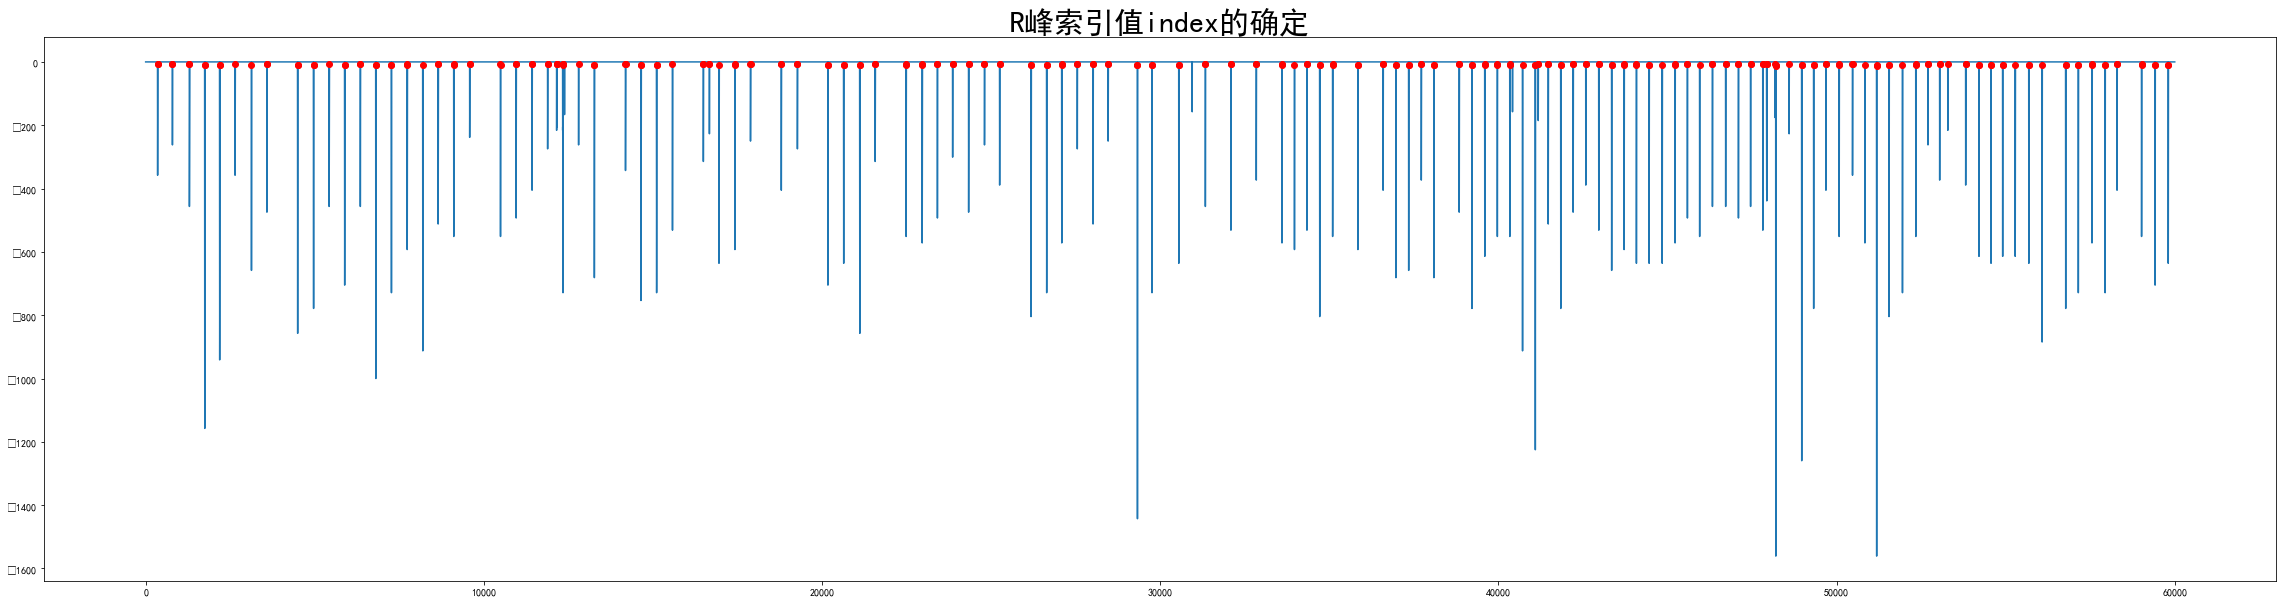

D:\miniconda3\install\envs\python36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\miniconda3\install\envs\python36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


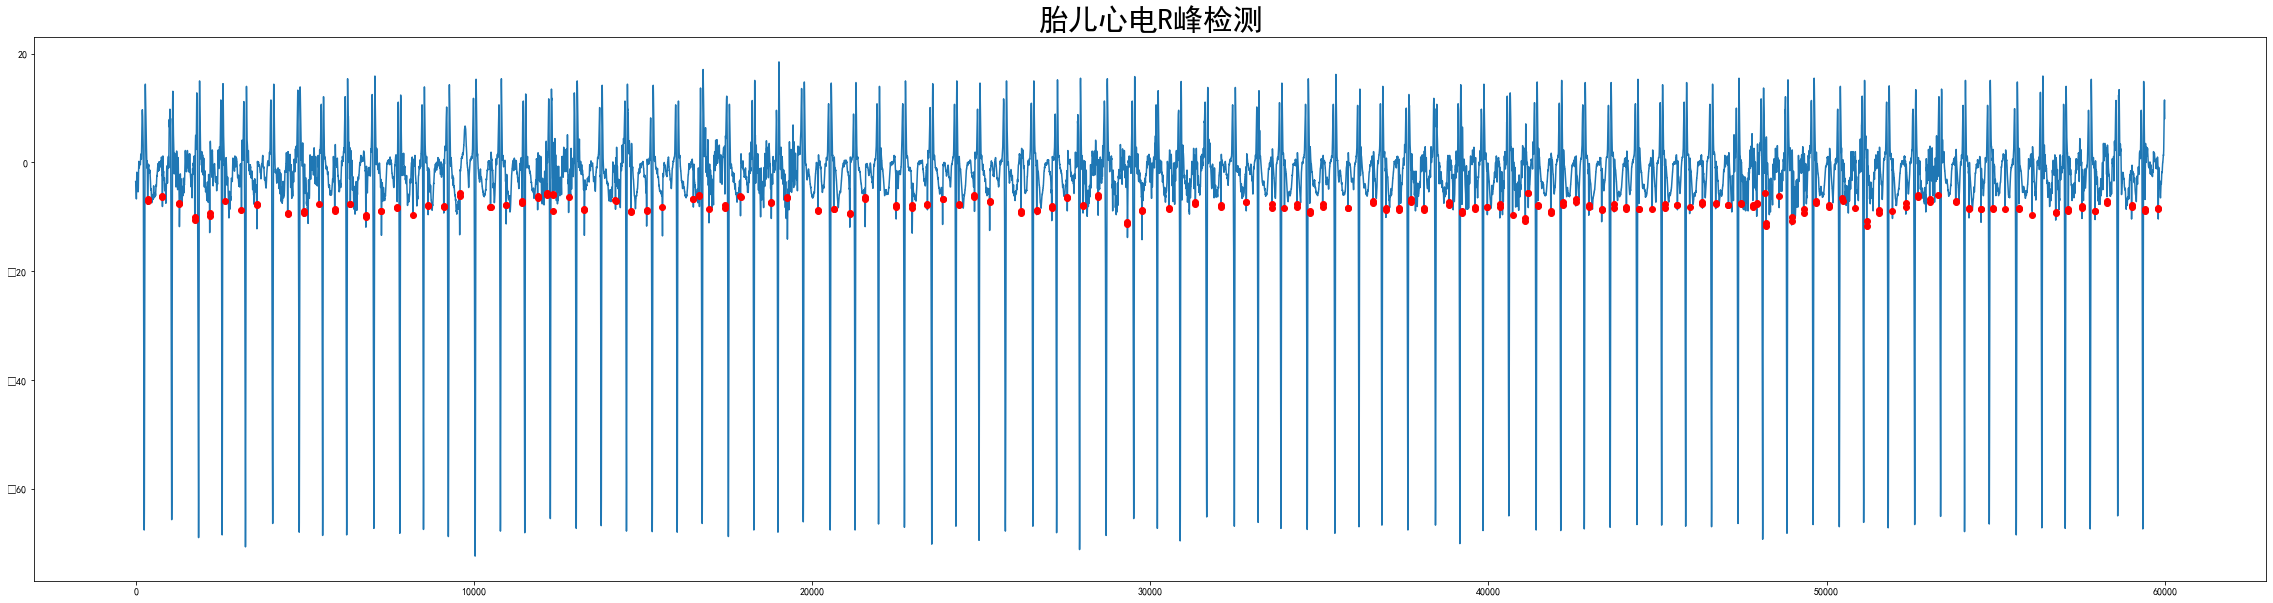

D:\miniconda3\install\envs\python36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\miniconda3\install\envs\python36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


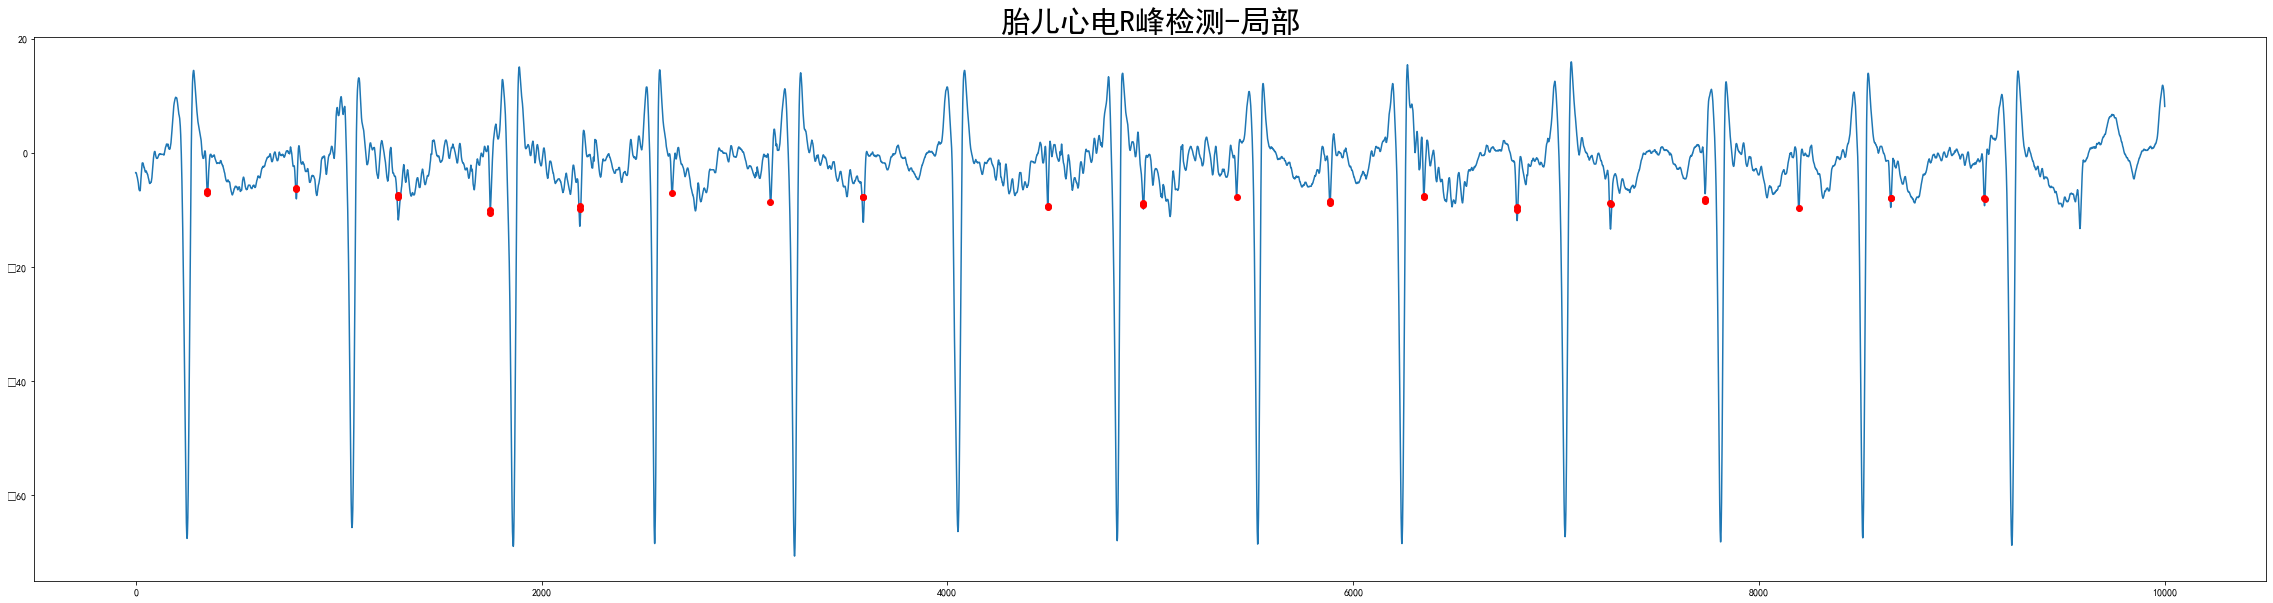

In [438]:
sigchild_pow3=sig_child**3  #首先对信号平方，拉大差距，便于找出R峰所在位置
mark1=min(sigchild_pow3)*0.1 #对小于R**2的值置零
L=sigchild_pow3.size  #L=60000，与原信号等长

for i in range(L):
    if sigchild_pow3[i]>mark1:
        sigchild_pow3[i]=0
        
        
sig_detectR=sigchild_pow3   

#对信号做一阶差分，根据极点知识找出R峰的位置
sig_diff=np.convolve(sig_detectR,np.array([1,-1]),"full")
indexR_child=[]  #R峰的横坐标值*1000
y_value=[]
for i in range(L-2):
    if sig_diff[i]*sig_diff[i+2]<0:
        indexR_child.append(i)
        y_value.append(sig_baseline[i])
        

        
plt.figure(1)
plt.plot(t*1000,sig_detectR)
plt.plot(indexR_child,y_value,"o",color="red")
plt.title("R峰索引值index的确定",fontsize=30)
plt.rcParams['figure.figsize'] = (40, 10) 
plt.show()

plt.figure(2)
plt.plot(t*1000,sig)
plt.plot(indexR_child,y_value,"o",color="red")
plt.title("胎儿心电R峰检测",fontsize=30)
plt.rcParams['figure.figsize'] = (40, 10) 
plt.show()

plt.figure(3)
plt.plot(t[:10000]*1000,sig[:10000])
plt.plot(indexR_child[:34],y_value[:34],"o",color="red")
plt.title("胎儿心电R峰检测-局部",fontsize=30)
plt.rcParams['figure.figsize'] = (40, 10) 
plt.show()

胎儿心拍的计算<br/>为了消除检测误差造成的心率影响，利用统计的方法得出心率

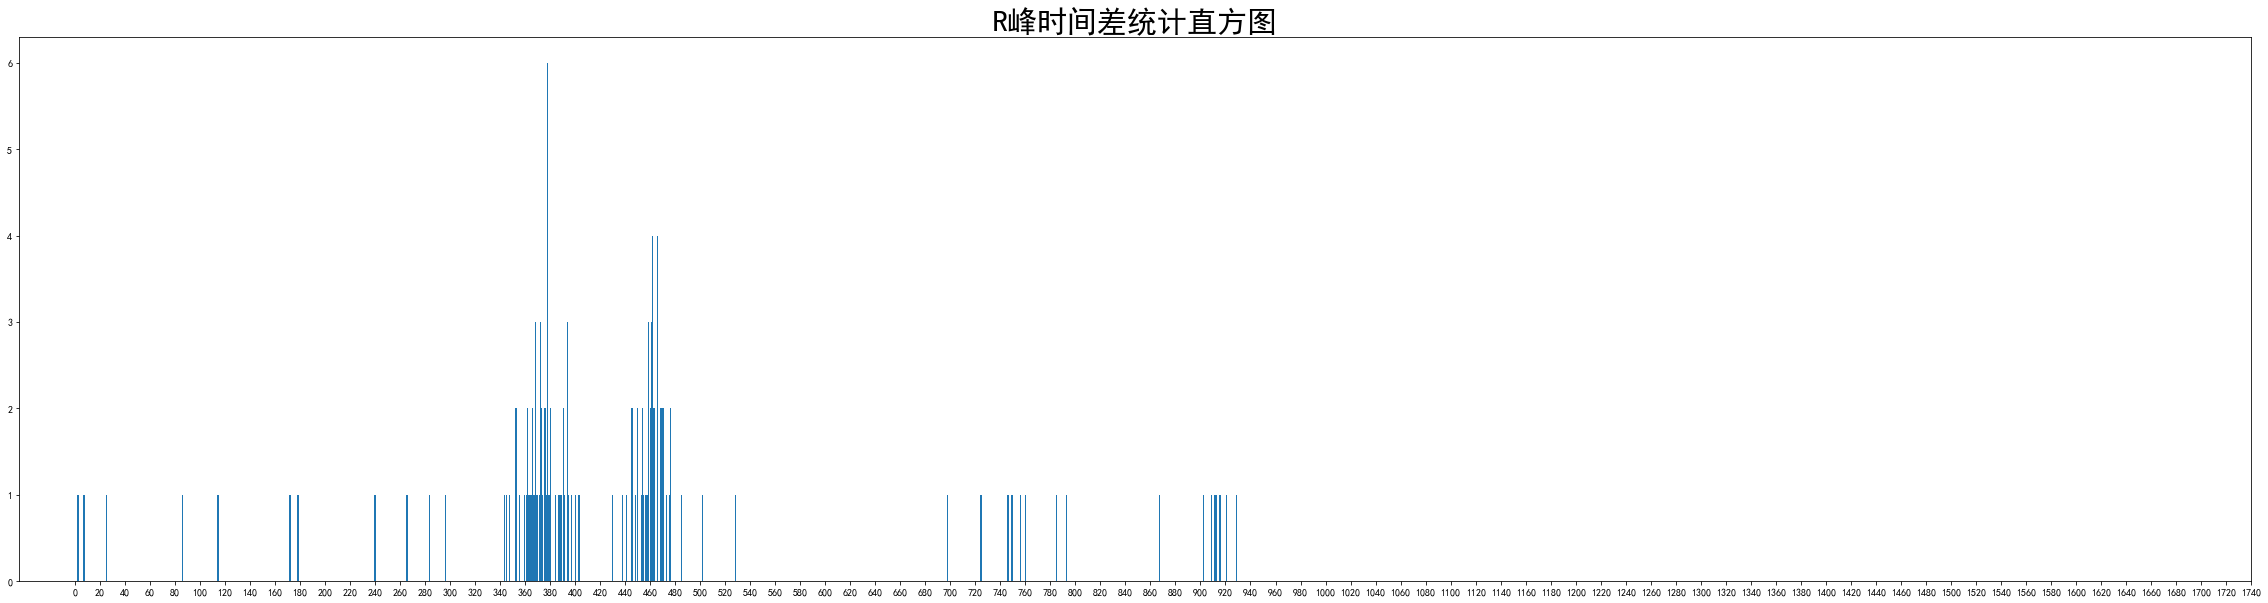

In [440]:
delta_T=[]
for j in range(len(indexR_child)-1):
    if indexR_child[j+1]-indexR_child[j]==1:
        indexR_child.remove(indexR_child[j+1])
    else:
        delta_T.append(indexR_child[j+1]-indexR_child[j])

plt.figure
plt.hist(delta_T,bins=1000)
plt.xticks(np.arange(0,1750,20))
plt.title("R峰时间差统计直方图",fontsize=30)
plt.rcParams['figure.figsize'] = (40, 10) 
plt.show()

In [441]:
counts, bin_edges = np.histogram(delta_T,bins=1000)
#心率计算
heart_rate=60/(bin_edges[np.argmax(counts[10:])]/1000)
print("胎率为：",int(heart_rate))

胎率为： 162
